In [6]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed      phase
Mean    -0.000004 -12.718223
Std      0.017427   4.972734
Var      0.000304  24.728081


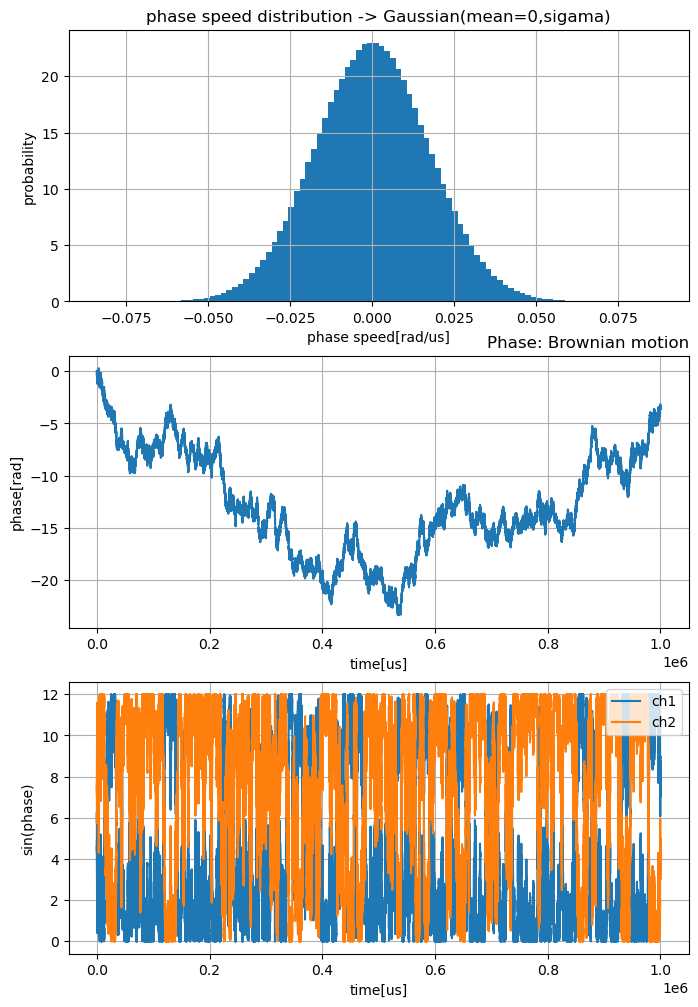

In [7]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=1/180*np.pi #rad/us
SIG_AMP=6 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [51]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    
def phase_to_dict(phase_measure_M4,phase_fb_M4,phase_measure_inter_M4,phase_fb_inter_M4,phase_M4):
    return dict(measure_quick=phase_measure_M4.tolist(),
                fb_quick=phase_fb_M4.tolist(),
                measure_inter=phase_measure_inter_M4.tolist(),
                fb_inter=phase_fb_inter_M4.tolist(),
                phase=phase_M4[:,-1].reshape(-1).tolist())

time_exposure=2 #us
time_inter=5
kp,ki=0.1,0
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
sig_ch1_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量量ch1
sig_ch2_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量量ch2
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量量
phase_measure_inter_M1=np.nan*np.zeros(phase_speed_M1.shape[0]) # 积分测量量
phase_fb_inter_M1=np.nan*np.zeros(phase_speed_M1.shape[0]) # 积分反馈量
phase_fb_M1=np.zeros(phase_speed_M1.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0

for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    sig_ch1_measure_M1[i]=ch1_measure
    sig_ch2_measure_M1[i]=ch2_measure
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)        
    phase_fb_M1[i]=kp*phase_measure_M1[i]
    
    ##-- 反馈 
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_fb_M1[i] # 反馈到下一个exposure
        ### 根据前time_inter*time_exposure项的积分去修正相位
        if i>100:
            phase_measure_inter_M1[i]=get_phase_from_count(sig_ch1_measure_M1[:i+1].sum(),sig_ch2_measure_M1[:i+1].sum())
            phase_fb_inter_M1[i]=ki*phase_measure_inter_M1[i]
            phase_speed_M1[i+1,0]-=phase_fb_inter_M1[i]

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

100%|██████████| 500000/500000 [00:33<00:00, 14827.84it/s]


      phase speed      phase  phase M1  phase M4 origin  phase M4 p1i0  \
Mean    -0.000004 -12.718223 -0.000214        -0.000125      -0.000919   
Std      0.017427   4.972734  0.073877         0.084683       0.084193   
Var      0.000304  24.728081  0.005458         0.007171       0.007088   

      phase M4 p1i1i1  phase M4 p1i1  
Mean        -0.000321      -0.000321  
Std          0.077315       0.077315  
Var          0.005978       0.005978  


### 改变权重

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_74040/3304720660.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_74040/3304720660.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_74040/3304720660.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Feedback weight: y=x when $x<a\sigma$ and \n y=a$\sigma+\Delta e^{-\Delta/b\si

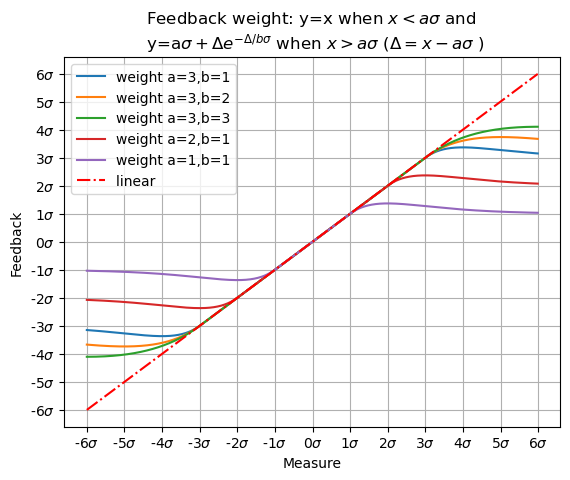

In [9]:
def fb_weight(measure, time_exposure,sigma=1,denominator=1):
    """denominator=1: 越大，权重越陡峭"""
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure/denominator))
    #weight=lambda x: np.sign(x) *(-(np.abs(x)/threshold-2)**2+2)*threshold
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    #split=0.314*phase_speed_in_measure
    #measure_filtered = np.where(np.abs(measure)<split, 0, measure_filtered)
    
    return measure_filtered

phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3,denominator=1),label='weight a={},b={}'.format(3,1))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3,denominator=2),label='weight a={},b={}'.format(3,2))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3,denominator=3),label='weight a={},b={}'.format(3,3))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=2,denominator=1),label='weight a={},b={}'.format(2,1))
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=1,denominator=1),label='weight a={},b={}'.format(1,1))
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<a\sigma$ and \n y=a$\sigma+\Delta e^{-\Delta/b\sigma}$ when $x>a\sigma$ ($\Delta =x-a\sigma$ )')
plt.show()

## PI_feedback  
$$
u_{k}=K_{p}Estimate(M_{k},a,b)+K_{i}Estimate(\sum_{i=1}^{k}M_{i},a,b)
$$  
其中$u_{k}$是反馈量,$K_{p}$和$K_{i}$是比例和积分增益,Estimate是估计函数,M_{k}是当前测量值,a和b是权重函数的系数.

In [39]:
time_exposure=2 #us
def simu_pi(phase_speed,time_exposure=2,time_inter=20,kp=1,ap=1,bp=1,ki=1,ai=1,bi=1):
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    sig_ch1_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch1
    sig_ch2_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch2
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
    phase_measure_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分测量量
    phase_fb_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量
    phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        sig_ch1_measure_M4[i]=ch1_measure
        sig_ch2_measure_M4[i]=ch2_measure
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)        
        phase_fb_M4[i]=kp*fb_weight(phase_measure_M4[i],time_exposure=time_exposure,
                                    sigma=ap,denominator=bp)
        
        ##-- 反馈 
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure
            ### 根据前time_inter*time_exposure项的积分去修正相位
            if i>=100:
                phase_measure_inter_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-time_inter:i+1].sum(),sig_ch2_measure_M4[i-time_inter:i+1].sum())
                phase_fb_inter_M4[i]=ki*fb_weight(phase_measure_inter_M4[i],time_exposure=time_inter*time_exposure,
                                                  sigma=ai,denominator=bi)
                phase_speed_M4[i+1,0]-=phase_fb_inter_M4[i]
                
                

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    #push_data(phase_out_M4,'phase M4 intergration')
    data_dict=phase_to_dict(phase_measure_M4,phase_fb_M4,
                        phase_measure_inter_M4,phase_fb_inter_M4,
                        phase_M4)
    return phase_out_M4,data_dict

phase_out,m4_p1i0=simu_pi(phase_speed=phase_speed,time_exposure=2,time_inter=5,
                        kp=0.30000000000000004,ap=1.5,bp=0.1,
                        ki=0.09,ai=2.0,bi=1.6)
push_data(phase_out,'phase M4 p1i1')

100%|██████████| 500000/500000 [00:10<00:00, 48808.52it/s]

      phase speed      phase  phase M1  phase M4 origin  phase M4 p1i0  \
Mean    -0.000004 -12.718223  0.000717        -0.000125      -0.000919   
Std      0.017427   4.972734  0.163095         0.084683       0.084193   
Var      0.000304  24.728081  0.026600         0.007171       0.007088   

      phase M4 p1i1i1  phase M4 p1i1  
Mean        -0.000321      -0.000321  
Std          0.077315       0.077315  
Var          0.005978       0.005978  


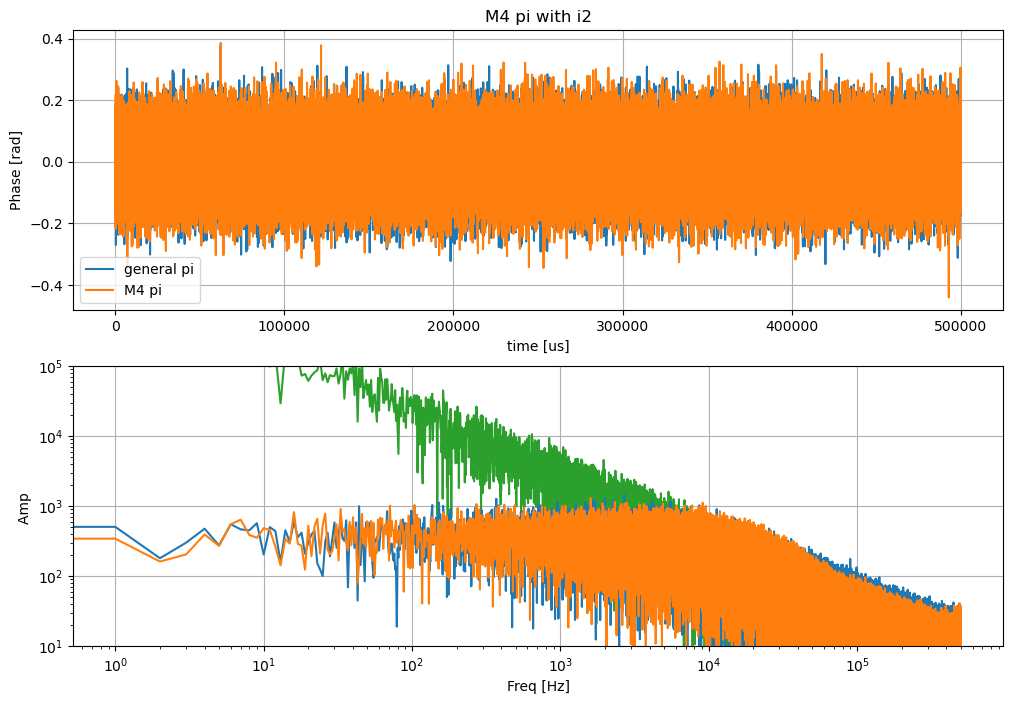

In [52]:
text='M4 pi with i2'
x0=0
x1=10000000
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(phase_out_M1[1::2][x0:x1],label='general pi')
plt.plot(phase_out[1::2][x0:x1],label='M4 pi')
plt.legend()
plt.title(text)
plt.ylabel('Phase [rad]')
plt.xlabel('time [us]')
plt.grid()

freq=np.fft.rfftfreq(phase_out.size,d=1e-6)
phase_fft=np.fft.rfft(phase_out)
phase_g_fft=np.fft.rfft(phase_out_M1)
phase_bg=np.fft.rfft(phase)
plt.subplot(212)
plt.loglog(freq,np.abs(phase_bg),label='background',color='C2')
plt.loglog(freq,np.abs(phase_g_fft),label='general pi',color='C0')
plt.loglog(freq,np.abs(phase_fft),label='M4 pi',color='C1')
plt.ylabel('Amp ')
plt.xlabel('Freq [Hz]')
plt.ylim(1e1,1e5)
plt.grid()